In [247]:
import psycopg
import sys
import credentials
import pandas as pd
from datetime import datetime
import numpy as np
import csv
import matplotlib.pyplot as plt
import warnings
from pandas import option_context
import plotly.graph_objects as go
from datetime import datetime, timedelta
import plotly.express as px


In [248]:
warnings.filterwarnings("ignore")

In [249]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [250]:
# Connect to remote machine
conn = psycopg.connect(
    host="sculptor.stat.cmu.edu", dbname=credentials.DB_USER,
    user=credentials.DB_USER, password=credentials.DB_PASSWORD
)

cur = conn.cursor()

In [251]:
# Need to add this as a param tag 
week = '2022-10-07'

In [252]:
with conn.transaction():
    result = cur.execute("SELECT quality_rating from rating \
        WHERE collection_date = %(week)s", params = {'week':week})

<p style="text-align:center;">
 <font size="10">
CMS and HHS Hospital Analytics Report

 </font>
 </p>


<p style="text-align:center;">
Colin Daniel, Tina Huang, Shurui Jin
</p>

## 1. A summary of how many hospital records were loaded in the most recent week, and how that compares to previous weeks.

In [265]:
# Read the data 
data_records = pd.read_sql_query("SELECT collection_date as date, count(collection_date) as count from beds \
        WHERE collection_date <= %(week)s \
        GROUP BY collection_date \
        ORDER By collection_date desc;", \
        conn, params = {'week':week})

# print(data_records)
# print(data_records['date'])
# print(data_records['count'])

dates = data_records['date']
records = data_records['count']

# Create a table 
list_dates = [date_obj.strftime('%Y-%m-%d') for date_obj in dates]
list_records = list(records)

# print(list_dates)
# print(list_records)

table = go.Figure(data = [go.Table(header=dict(values=['<b> Date <b>', '<b> Number of Records <b>'], 
                                            font_size=20, height=50, align=['center', 'center', 'center', 'center']),
                 cells=dict(values=[list_dates, list_records], 
                 font_size=20, height=50, align=['center', 'center', 'center', 'center']))
        ])

table.update_layout(
  margin=dict(l=50, r=50, t=50, b=0)
)

table.show()

## 2. Summary table of the amount of total beds in use and avaiable for Adults and Children as well as total Hospitalized Covid Cases for each Week.

In [254]:

summary_beds = pd.read_sql_query(
    "SELECT b.collection_date, Adult_Beds_free, child_beds_free, \
    adult_beds_in_use, child_beds_in_use, total_covid_cases FROM \
    (SELECT collection_date, SUM(adult_beds_weekly_avg) as Adult_Beds_free, \
    SUM(pediatric_beds_weekly_avg) as child_beds_free, \
    SUM(adult_beds_occupied_weekly_avg) as adult_beds_in_use, \
    SUM(pediatric_beds_occupied_weekly_avg) as child_beds_in_use FROM beds \
    GROUP BY collection_date HAVING collection_date <= %(week)s) as b \
    INNER JOIN (SELECT collection_date, \
    SUM(patients_confirmed_covid_weekly_avg) as total_covid_cases \
    FROM Patients GROUP BY collection_date \
    HAVING collection_date <= %(week)s) as p \
    ON b.collection_date = p.collection_date ORDER BY \
    b.collection_date Desc", conn, params={'week':week})

summary_beds = summary_beds.rename(columns={"collection_date":"Date", "adult_beds_free":"Adult Beds Free", 
"child_beds_free":"Child Beds Free", "adult_beds_in_use":"Adult Beds in Use", "child_beds_in_use":"Child Beds in Use",
"total_covid_cases":"Covid Cases"})

list1 = summary_beds["Date"]
list2 = summary_beds['Adult Beds Free']
list3 = summary_beds['Child Beds Free']
list4 = summary_beds['Adult Beds in Use']
list5 = summary_beds['Child Beds in Use']
list6 = summary_beds['Covid Cases']



table = go.Figure(data = [go.Table(header = dict(values = ['<b> Date <b>', '<b> Adult Beds Free <b>', '<b> Child Beds Free <b>', '<b> Adult Beds in Use <b>', '<b> Child Beds in Use <b>', '<b> Covid Cases <b>'], font_size=20, height=50),
                                                cells = dict(values=[list1, list2, list3, list4, list5, list6], font_size=20, height=50))]

                                
)

table.update_layout(autosize=True, margin=dict(r=50, l=50, t=50, b=0))


table.show()





## 3. The fraction of beds currently in use by hospital quality rating

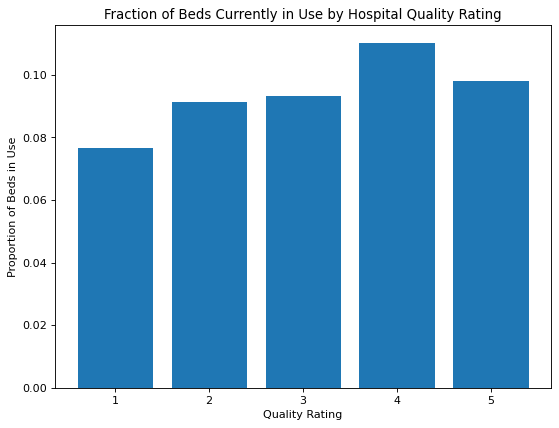

In [255]:
beds = pd.read_sql_query(
    "select b.quality_rating, sum(coalesce(a.adult_beds_weekly_avg,0)) + sum(coalesce(a.pediatric_beds_weekly_avg,0)) as total_bed, \
    sum(coalesce(a.adult_beds_occupied_weekly_avg,0)) + sum(coalesce(a.pediatric_beds_occupied_weekly_avg,0)) as total_bed_used \
    from beds as a inner join ( select b.hospital_pk, b.quality_rating from \
    (select a.*, (rank() OVER (PARTITION BY hospital_pk ORDER BY collection_date desc)) as rank \
    from Rating as a where collection_date <= %(week)s and quality_rating != -1) as b where rank = 1) \
    b ON a.hospital_pk = b.hospital_pk and a.collection_date = %(week)s \
    group by b.quality_rating order by b.quality_rating;", conn, params={'week':week})


beds = beds.rename(columns={"quality_rating":"Quality Rating", 
"total_bed":"Total Beds Available", "total_bed_used":"Total Beds In Use"})

f = plt.figure(figsize=(8,6), dpi=80)


p = plt.bar(beds["Quality Rating"], (beds["Total Beds In Use"] / beds["Total Beds Available"]))
p = plt.title("Fraction of Beds Currently in Use by Hospital Quality Rating")
p = plt.xlabel("Quality Rating")
p = plt.ylabel("Proportion of Beds in Use")
plt.show()

## 4. The total number of hospital beds used per week, over all time, split into all cases and COVID cases

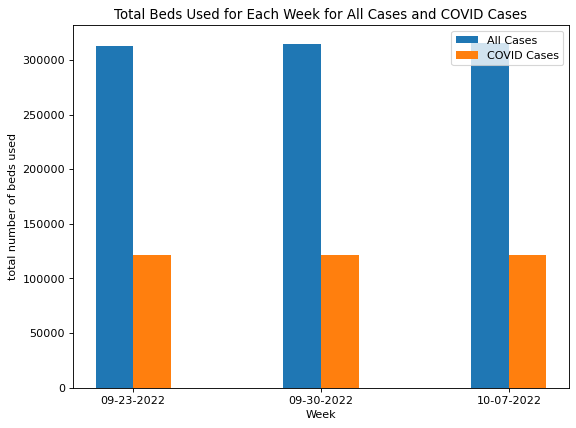

In [256]:

beds2 = pd.read_sql_query("select to_char(beds.collection_date, 'mm-dd-YYYY') as week, \
        sum(coalesce(beds.adult_beds_occupied_weekly_avg,0)) + \
        sum(coalesce(beds.pediatric_beds_occupied_weekly_avg,0)) as All_cases, \
        sum(coalesce(patients.patients_confirmed_covid_weekly_avg,0)) as COVID_cases\
        from beds FULL OUTER JOIN patients ON beds.hospital_pk = patients.hospital_pk\
        where beds.collection_date <= %(week)s group by beds.collection_date order by beds.collection_date;" , conn, params={'week':week})

beds2 = beds2.rename(columns={"week":"Week", "all_cases":"All Cases", "covid_cases":"Covid Cases"})

x = np.arange(len(beds2["Week"]))

f = plt.figure(figsize=(8,6), dpi=80)

p = plt.bar(x - 0.1, beds2["All Cases"],  0.2, label = "All Cases")
p = plt.bar(x + 0.1, beds2["Covid Cases"],  0.2, label = "COVID Cases")
p = plt.xticks(x, beds2["Week"])
p = plt.title("Total Beds Used for Each Week for All Cases and COVID Cases")
p = plt.xlabel("Week")
p = plt.ylabel("total number of beds used")
p = plt.legend(loc='upper right')
plt.show()

## 5. The percent of available beds being used by type of hospital (private or public), over time

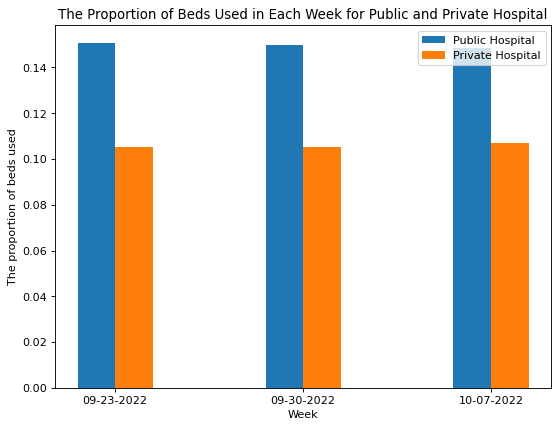

In [257]:

beds_public = pd.read_sql_query("select to_char(beds.collection_date, 'mm-dd-YYYY') as week, \
        sum(coalesce(beds.adult_beds_weekly_avg,0)) + sum(coalesce(beds.pediatric_beds_weekly_avg,0)) as total_bed, \
        sum(coalesce(beds.adult_beds_occupied_weekly_avg,0)) + sum(coalesce(beds.pediatric_beds_occupied_weekly_avg,0)) as total_bed_used \
        from beds FULL OUTER JOIN Hospital ON beds.hospital_pk = Hospital.hospital_pk\
        where beds.collection_date <= %(week)s and (Hospital.Hospital_Ownership LIKE 'Government - Federal'\
        or Hospital.Hospital_Ownership LIKE 'Government - Hospital District or Authority' \
        or Hospital.Hospital_Ownership LIKE 'Government - Local' \
        or Hospital.Hospital_Ownership LIKE 'Government - State' \
        or Hospital.Hospital_Ownership LIKE 'Tribal') \
        group by beds.collection_date order by beds.collection_date;" , conn, params={'week':week})


beds_private = pd.read_sql_query("select to_char(beds.collection_date, 'mm-dd-YYYY') as week, \
        sum(coalesce(beds.adult_beds_weekly_avg,0)) + sum(coalesce(beds.pediatric_beds_weekly_avg,0)) as total_bed, \
        sum(coalesce(beds.adult_beds_occupied_weekly_avg,0)) + sum(coalesce(beds.pediatric_beds_occupied_weekly_avg,0)) as total_bed_used \
        from beds FULL OUTER JOIN Hospital ON beds.hospital_pk = Hospital.hospital_pk\
        where beds.collection_date <= %(week)s and (Hospital.Hospital_Ownership LIKE 'Proprietary'\
        or Hospital.Hospital_Ownership LIKE 'Physician' \
        or Hospital.Hospital_Ownership LIKE 'Voluntary non-profit - Church' \
        or Hospital.Hospital_Ownership LIKE 'Voluntary non-profit - Other') \
        group by beds.collection_date order by beds.collection_date;" , conn, params={'week':week})



beds_public = beds_public.rename(columns={"week":"Week", "total_bed":"Total Beds Available", "total_bed_used":"Total Beds In Use"})
beds_private = beds_private.rename(columns={"week":"Week", "total_bed":"Total Beds Available", "total_bed_used":"Total Beds In Use"})

x = np.arange(len(beds2["Week"]))

f = plt.figure(figsize=(8,6), dpi=80)

p = plt.bar(x - 0.1, beds_public["Total Beds In Use"] / beds_public["Total Beds Available"],  0.2, label = "Public Hospital")
p = plt.bar(x + 0.1, beds_private["Total Beds In Use"] / beds_private["Total Beds Available"],  0.2, label = "Private Hospital")
p = plt.xticks(x, beds_public["Week"])
p = plt.title("The Proportion of Beds Used in Each Week for Public and Private Hospital")
p = plt.xlabel("Week")
p = plt.ylabel("The proportion of beds used")
p = plt.legend(loc='upper right')
plt.show()



## 6. A map showing the number of COVID cases by state.

In [258]:
# Extract data from the database
covid_Patients = pd.read_sql_query(
        "SELECT state, sum(cases) as covid_cases from \
        (SELECT hospital.state as state, \
                coalesce(nullif(patients.patients_confirmed_covid_weekly_avg, 'NaN'), 0) as cases \
        FROM hospital, patients \
        WHERE hospital.hospital_pk = patients.hospital_pk AND \
                patients.collection_date = %(week)s) x1\
        GROUP BY state ORDER BY state;", 
        conn, params = {'week':week}) 

# Plot the map
fig = px.choropleth(covid_Patients,
                    locations='state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='covid_cases',
                    color_continuous_scale="viridis_r",   
                    )

fig.update_layout(
      title_text = 'Average Weekly COVID Cases by State',
      legend_title = "Average Covid Cases",
      title_font_family="Arial",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45, 
    )

fig.show()

## 7. Hospitals with Covid Increases in the Last Week

In [263]:
covid_inc = pd.read_sql_query(
    "SELECT hospital_name, city, geo_coded_hospital_address as Coordinates, \
    7*(covid_2 - covid_1) as New_Cases FROM (SELECT * FROM Hospital) as c \
    INNER JOIN (SELECT * FROM (SELECT collection_date, \
    SUM(coalesce(nullif(patients_confirmed_covid_weekly_avg, 'NaN'), 0)) as covid_1, \
    hospital_pk as pid FROM Patients GROUP BY pid, collection_date \
    HAVING collection_date = %(week)s) as a INNER JOIN \
    (SELECT collection_date, \
    SUM(coalesce(nullif(patients_confirmed_covid_weekly_avg, 'NaN'), 0)) as covid_2, \
    hospital_pk as pid_2 FROM Patients GROUP BY pid_2, collection_date \
    HAVING collection_date = %(week)s::DATE -7) as b ON a.pid = b.pid_2) as d \
    ON c.hospital_pk = d.pid ORDER BY New_Cases DESC limit 10;", \
    conn, params={'week':week})


covid_inc = covid_inc.rename(columns={"hospital_name":"Hospital Name", "city":"City", 
"coordinates":"Coordinates", "new_cases":"New Cases"})


list1 = covid_inc["Hospital Name"]
list2 = covid_inc['City']
list3 = covid_inc['Coordinates']
list4 = covid_inc['New Cases']

table = go.Figure(data = [go.Table(header = dict(values = ['<b> Hospital Name <b>', '<b> City <b>', '<b> Coordinates <b>', '<b> New Cases <b>'], font_size=20, height=50),
                                                cells = dict(values=[list1, list2, list3, list4], font_size=20, height=50))]

                                
)

table.update_layout(autosize=True, margin=dict(r=50, l=50, t=50, b=0))


table.show()


                  hospital_name                     city          coordinates        new_cases
0      THE UNIVERSITY OF CHICAGO MEDICAL CENTER     CHICAGO    (-87.60492,41.78869)    116.9  
1  UNIVERSITY OF CINCINNATI MEDICAL CENTER, LLC  CINCINNATI  (-84.502562,39.136728)    112.7  
2                    HOUSTON METHODIST HOSPITAL     HOUSTON  (-95.400194,29.710477)    112.7  
3                NORTHWESTERN MEMORIAL HOSPITAL     CHICAGO  (-87.621638,41.894989)     96.6  
4     ATRIUM HEALTH NAVICENT THE MEDICAL CENTER       MACON  (-83.636553,32.833202)     86.8  
5            STEWARD NORTH SHORE MEDICAL CENTER       MIAMI  (-80.214728,25.861655)     86.1  
6                  WELLSTAR COBB MEDICAL CENTER     AUSTELL    (-84.60169,33.85651)     81.9  
7            METHODIST MANSFIELD MEDICAL CENTER   MANSFIELD    (-97.09715,32.56849)     79.1  
8                    SARASOTA MEMORIAL HOSPITAL    SARASOTA  (-82.529686,27.318219)     78.4  
9                    HCA FLORIDA BLAKE HOSPITAL   